## TODO
- look at the negative isoform pairs that are testing positive
- think about why the RRS rate is different between different RRS sets
    - is there a difference between how they are selected
    - is the difference significant given how large the sets are?

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from ccsblib import paros_connection
from ccsblib.ccsbplotlib import validation_plot, checkerboard

from data_loading import load_isoform_and_paralog_y2h_data

In [2]:
qry = """select a.test_orf_ida, a.test_orf_idb, a.test_pla, a.test_pos, b.score
from tf_validation.validation_cp AS a
left join tf_validation.mn2h_scoring AS b
on a.standard_batch = b.standard_batch
and a.test_pla_full = b.plate
and a.test_pos = b.well
where a.standard_batch = 'TFv02';"""
df = pd.read_sql(qry, paros_connection())
qry = """select orf_id1, orf_id2, source
from tf_validation.validation_source
where standard_batch = 'TFv02';"""
source = pd.read_sql(qry, paros_connection())
source['pair'] = source[['orf_id1', 'orf_id2']].min(axis=1).astype(str) + '_' + source[['orf_id1', 'orf_id2']].max(axis=1).astype(str)
df['pair'] = df[['test_orf_ida', 'test_orf_idb']].min(axis=1).astype(str) + '_' + df[['test_orf_ida', 'test_orf_idb']].max(axis=1).astype(str)
df = pd.merge(df, source.loc[:, ['pair', 'source']], how='left', on='pair')
df.loc[(df['test_orf_ida'] == 0) & (df['test_orf_idb'] != 0), 'source'] = 'empty-N1_control'
df.loc[(df['test_orf_idb'] == 0) & (df['test_orf_ida'] != 0), 'source'] = 'empty-N2_control'
df.loc[df['test_pos'].isin(['B02', 'C02']), 'source'] = 'SKP1-SKP2_control'
df.loc[df['test_pos'].isin(['D02', 'E02']), 'source'] = 'SKP1-BTRC_control'
if df['source'].isnull().any():
    raise UserWarning('something wrong')
controls = df.loc[df['source'].isin(['SKP1-SKP2_control', 'SKP1-BTRC_control']), :].copy()
df = df.loc[~df['source'].isin(['SKP1-SKP2_control', 'SKP1-BTRC_control']), :]

In [3]:
# remove low liquid pairs
missing = pd.read_excel('../one_off/TFv02_empty_wells_after_cp.xlsx', sheet_name='Empty destination wells')
missing['Destination_plate'] = missing['Destination_plate'].str.slice(0, -3)
missing['Destination_well'] = missing['Destination_well'].apply(lambda x: x[0] + str(x[1:]).zfill(2))
df.loc[(df['test_pla'].astype(str).str.zfill(3) + 
        df['test_pos']).isin((missing['Destination_plate'].str.slice(-3) + missing['Destination_well']).values),
        'score'] = np.nan

In [4]:
# remove low DNA count pairs
qry = """
  select test_orf_id, vector , concentration_working_copy 
   from tf_validation.validation_nodes_final 
   where concentration_working_copy < 8 
   and node_pla_dna_working_copy  not like '%Low%'  ;
"""
low_dna = pd.read_sql(qry, paros_connection())
df.loc[df['test_orf_ida'].isin(low_dna.loc[low_dna['vector'] == 'N1', 'test_orf_id'].values), 'score'] = np.nan
df.loc[df['test_orf_idb'].isin(low_dna.loc[low_dna['vector'] == 'N2', 'test_orf_id'].values), 'score'] = np.nan

In [5]:
# match empty N1/N2 controls
tmp_df = pd.merge(df.loc[~df['source'].isin(['empty-N1_control', 'empty-N2_control']), :],
         df.loc[df['source'] == 'empty-N1_control', ['test_orf_idb', 'test_pla', 'test_pos', 'score']],
         on=['test_orf_idb', 'test_pla'],
         how='left',
         suffixes=('_pair', '_empty-N1')
)
df = pd.merge(tmp_df,
         df.loc[df['source'] == 'empty-N2_control', ['test_orf_ida', 'test_pla', 'test_pos', 'score']],
         on=['test_orf_ida', 'test_pla'],
         how='left').rename(columns={'test_pos': 'test_pos_empty-N2', 'score': 'score_empty-N2'})


# 23 -> plate 1
# 24 -> plate 2
# 25 -> plate 1, empty-N2
# 26 -> plate 1, empty-N1
# 27 -> plate 2, empty-N2
# 28 -> plate 2, empty-N1
qry = """select plate, well, score
from tf_validation.mn2h_scoring AS b
where standard_batch = 'TFv02'
and plate between 'TFv02N2H_023' and 'TFv02N2H_028';"""
prs = pd.read_sql(qry, paros_connection())
prs = pd.concat([
    (prs.loc[prs['plate'].isin(['TFv02N2H_023', 'TFv02N2H_025', 'TFv02N2H_026']), :]
    .pivot_table(index='well', columns='plate', values='score')
    .reset_index()
    .rename(columns={'TFv02N2H_023': 'score_pair', 'TFv02N2H_025': 'score_empty-N2', 'TFv02N2H_026': 'score_empty-N1'})
    .assign(plate=1)),
    (prs.loc[prs['plate'].isin(['TFv02N2H_024', 'TFv02N2H_027', 'TFv02N2H_028']), :]
    .pivot_table(index='well', columns='plate', values='score')
    .reset_index()
    .rename(columns={'TFv02N2H_024': 'score_pair', 'TFv02N2H_027': 'score_empty-N2', 'TFv02N2H_028': 'score_empty-N1'})
    .assign(plate=2))
])
qry = """select plate, well, orf_ida as test_orf_ida, orf_idb as test_orf_idb, category as source
         from n2h.prsrrs
         where is_v2 = 1;"""
prs = pd.merge(prs,
         pd.read_sql(qry, paros_connection()),
         how='inner',
         on=['plate', 'well'])

prs['pair'] = prs[['test_orf_ida', 'test_orf_idb']].min(axis=1).astype(str) + '_' + prs[['test_orf_ida', 'test_orf_idb']].max(axis=1).astype(str)
prs = prs.rename(columns={'well': 'test_pos_pair'})
prs['test_pos_empty-N1'] = prs['test_pos_pair']
prs['test_pos_empty-N2'] = prs['test_pos_pair']
prs['test_pla'] = prs['plate'].map({1: 23, 2: 24})
prs = prs.drop(columns=['plate'])
df = pd.concat([df, prs], ignore_index=True)


# TMP
df = df.dropna()

# this will no longer work after removing low DNA pairs
if df.isnull().any().any():
    raise UserWarning('unexpected missing values')
df['NLR'] = df['score_pair'] / df[['score_empty-N1', 'score_empty-N2']].max(axis=1)
df['log2 NLR'] = df['NLR'].apply(np.log2)
df['source'] = df['source'].apply(lambda x: {'isoform_matched_negatives': 'isoform_negatives'}.get(x, x))
df = df.drop_duplicates()
df['source'] = df['source'].map({
    'whole_tf_genes': 'vignettes', 
    'isoform_positives': 'isoform positives',
     'TF_RRS': 'RRS - TF space specific',
      'litbm': 'Lit-BM - TF space specific',
       'isoform_negatives': 'isoform negatives',
        'huri_rrs': 'RRS - from HuRI',
        'lit_bm_2013_rand250': 'Lit-BM-13',
        'PRS': 'PRS - hPRS-v2',
        'RRS': 'RRS - hRRS-v2'})
df['score_pair_log10'] = df['score_pair'].apply(np.log10)
df['score_empty-N1_log10'] = df['score_empty-N1'].apply(np.log10)
df['score_empty-N2_log10'] = df['score_empty-N2'].apply(np.log10)

In [6]:
# sequence confirmation was done after the expeirment design
# so need to remove sequence failures
y2h = load_isoform_and_paralog_y2h_data()
y2h = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :]
y2h_positives = y2h.loc[y2h['Y2H_result'] == True, ['ad_orf_id', 'db_orf_id']].values
y2h_positives = set(map(tuple, y2h_positives))
y2h_negatives = y2h.loc[y2h['Y2H_result'] == False, ['ad_orf_id', 'db_orf_id']].values
y2h_negatives = set(map(tuple, y2h_negatives))

# check positives / negatives are in Y2H dataset
def in_y2h_positves(row):
    pair = (row['test_orf_idb'],
            row['test_orf_ida'])
    return pair in y2h_positives


def in_y2h_negatives(row):
    pair = (row['test_orf_idb'],
            row['test_orf_ida'])
    return pair in y2h_negatives


df = df.loc[~((df['source'] == 'isoform positives') & 
            ~df.apply(in_y2h_positves, axis=1)), :]
df = df.loc[~((df['source'] == 'isoform negatives') & 
            ~df.apply(in_y2h_negatives, axis=1)), :]

In [7]:
COLOR_LIT = (60 / 255, 134 / 255, 184 / 255)
COLOR_HURI = (155 / 255, 97 / 255, 153 / 255)
colors = {    
    'vignettes': 'yellow', 
    'isoform positives': COLOR_HURI,
     'RRS - TF space specific': 'tab:red',
      'Lit-BM - TF space specific': COLOR_LIT,
       'isoform negatives': 'grey',
        'RRS - from HuRI': 'tab:red',
        'Lit-BM-13': COLOR_LIT,
        'PRS - hPRS-v2': COLOR_LIT,
        'RRS - hRRS-v2': 'tab:red'}

In [7]:
# DEBUG -- what's with the cases where there are identical readings?
# They appear that way in the raw data from the experiment
df.loc[df['NLR'] == 1]

,test_orf_ida,test_orf_idb,test_pla,test_pos_pair,score_pair,pair,source,test_pos_empty-N1,score_empty-N1,test_pos_empty-N2,score_empty-N2,NLR,log2 NLR,score_pair_log10,score_empty-N1_log10,score_empty-N2_log10
1,12504,101256,1,A04,6709.0,12504_101256,vignettes,A03,137.0,A05,6709.0,1.0,0.0,3.826658,2.136721,3.826658
130,100066358,101221,3,E04,130.0,101221_100066358,vignettes,A10,130.0,D04,130.0,1.0,0.0,2.113943,2.113943,2.113943
423,3092,100313,10,B06,1119.0,3092_100313,isoform positives,A06,103.0,B07,1119.0,1.0,0.0,3.048830,2.012837,3.048830
569,56139,101350,14,E06,144.0,56139_101350,RRS - TF space specific,E08,96.0,E07,144.0,1.0,0.0,2.158362,1.982271,2.158362
614,70764,1102,16,A04,124.0,1102_70764,RRS - from HuRI,A06,103.0,A05,124.0,1.0,0.0,2.093422,2.012837,2.093422
925,9802,4568,24,F09,110.0,4568_9802,RRS - hRRS-v2,F09,96.0,F09,110.0,1.0,0.0,2.041393,1.982271,2.041393


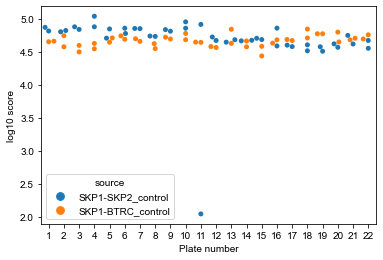

In [159]:
controls['log10 score'] = controls['score'].apply(np.log10)
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=controls, y='log10 score', x='test_pla', hue='source', ax=ax)
ax.set_xlabel('Plate number')
fig.savefig('../figures/TFv02_controls_per-plate.pdf',
            bbox_inches='tight')

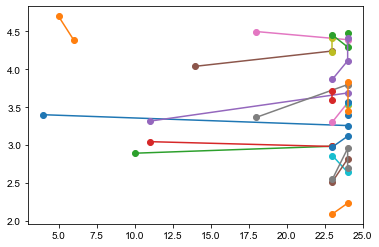

In [32]:
# find repeat tests
n1 = df.loc[:, ['test_orf_ida', 'test_pla', 'score_empty-N2_log10']].drop_duplicates()
n1 = n1.loc[n1['test_orf_ida'].map(n1.groupby('test_orf_ida').size() > 1)]
fig, ax = plt.subplots(1, 1)
for orf_id in n1['test_orf_ida'].unique():
    ax.plot(n1.loc[n1['test_orf_ida'] == orf_id, 'test_pla'].values,
            n1.loc[n1['test_orf_ida'] == orf_id, 'score_empty-N2_log10'].values,
            '-o')

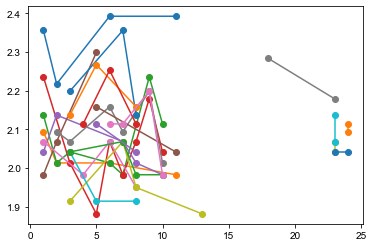

In [33]:
n1 = df.loc[:, ['test_orf_idb', 'test_pla', 'score_empty-N1_log10']].drop_duplicates()
n1 = n1.loc[n1['test_orf_idb'].map(n1.groupby('test_orf_idb').size() > 1)]
fig, ax = plt.subplots(1, 1)
for orf_id in n1['test_orf_idb'].unique():
    ax.plot(n1.loc[n1['test_orf_idb'] == orf_id, 'test_pla'].values,
            n1.loc[n1['test_orf_idb'] == orf_id, 'score_empty-N1_log10'].values,
            '-o')

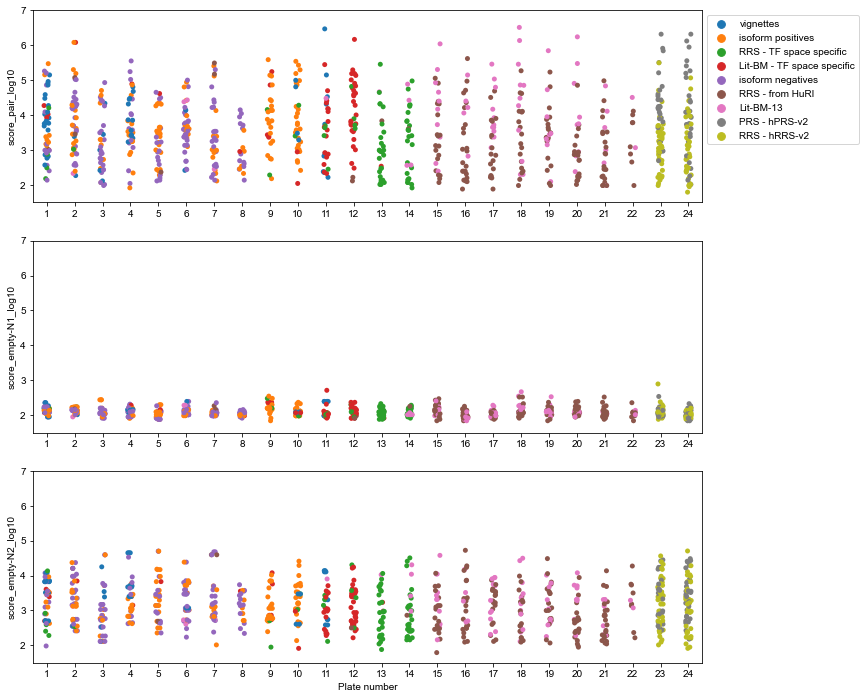

In [8]:
# NOTE: the plate numbers here for the controls for the PRS/RRS are incorrect
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(h=12, w=12)
sns.stripplot(data=df, y='score_pair_log10', x='test_pla', hue='source', ax=axs[0])
sns.stripplot(data=df, y='score_empty-N1_log10', x='test_pla', hue='source', ax=axs[1])
sns.stripplot(data=df, y='score_empty-N2_log10', x='test_pla', hue='source', ax=axs[2])
for ax in axs:
    ax.set_ylim(1.5, 7)
axs[0].legend(bbox_to_anchor=(1., 1.))
axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('Plate number')
fig.savefig('../figures/TFv02_scores-by-plate-and-category.pdf',
            bbox_inches='tight')

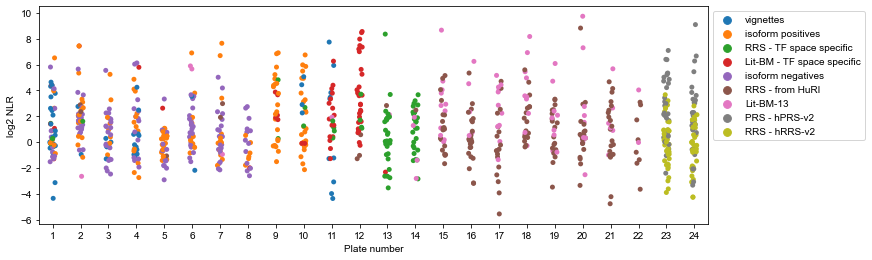

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(h=4, w=12)
sns.stripplot(data=df, y='log2 NLR', x='test_pla', hue='source', ax=ax)
ax.legend(bbox_to_anchor=(1., 1.))
ax.set_xlabel('Plate number')
fig.savefig('../figures/TFv02_NLR-by-plate-and-category.pdf',
            bbox_inches='tight')

In [8]:
df['source'].value_counts()

RRS - from HuRI               157
isoform positives             133
isoform negatives             133
RRS - hRRS-v2                  78
Lit-BM-13                      75
RRS - TF space specific        71
Lit-BM - TF space specific     62
PRS - hPRS-v2                  60
vignettes                      56
Name: source, dtype: int64

In [197]:
df['source'].unique()

array(['vignettes', 'isoform positives', 'RRS - TF space specific',
       'Lit-BM - TF space specific', 'isoform negatives',
       'RRS - from HuRI', 'Lit-BM-13', 'PRS - hPRS-v2', 'RRS - hRRS-v2'],
      dtype=object)

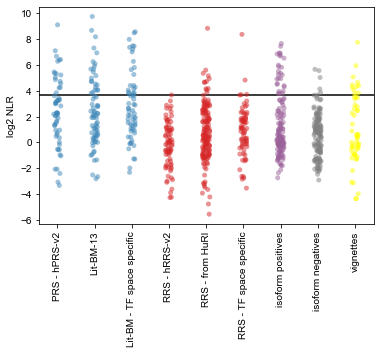

In [35]:
sources = [
           'PRS - hPRS-v2', 
            'Lit-BM-13', 
            'Lit-BM - TF space specific',
            'RRS - hRRS-v2',
            'RRS - from HuRI', 
            'RRS - TF space specific',
            'isoform positives', 
            'isoform negatives',
            'vignettes',
           ]
fig, ax = plt.subplots(1, 1)
sns.stripplot(data=df, 
              x='source',
              y='log2 NLR', 
              order=sources,
              ax=ax,
              alpha=0.5,
              palette=colors)
ax.tick_params(axis="x", rotation=90)
ax.axhline(y=df.loc[df['source'] == 'RRS - hRRS-v2', 'log2 NLR'].max(), color='black')
ax.set_xlabel('')
fig.savefig('../figures/TFv02_categories_points.pdf',
            bbox_inches='tight')

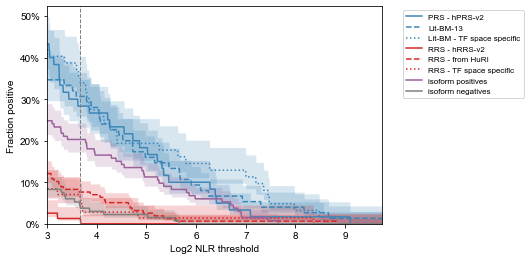

In [10]:
# titration plot
def validation_titration_plot(data, 
                              selections,
                              threshold=None,
                              xmin=None,
                              xmax=None,
                              ymax=None,
                              score_column='score',
                              labels=None,
                              colors=None,
                              line_styles=None,
                              ax=None,
                              threshold_label=None,
                              threshold_color='grey',
                              plot_kwargs=None):
    """
    - error bars
    
    """
    if ax is None:
        ax = plt.gca()
    if labels is None:
        labels = [''] * len(selections)
    if colors is None:
        colors = [None] * len(selections)
    if line_styles is None:
        line_styles = ['-'] * len(selections)
    if xmin is None:
        xmin = data[score_column].min()
    if xmax is None:
        xmax = data[score_column].max()
    n_points = 1000  # TODO: this is a bad way to do it, would be better to just get every point where there is a pair
    points = np.linspace(xmin, xmax, n_points)
    for selection, label, color, line_style in zip(selections, labels, colors, line_styles):
        n = data.loc[selection, score_column].notnull().sum()
        pos = np.array([(data.loc[selection, score_column] > x).sum() for x in points])
        neg = n - pos
        fracs = pos / n
        ax.plot(points, fracs, label=label, color=color, linestyle=line_style)#BUG , **plot_kwargs)
        intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
        errs = [fracs - intv[0], intv[1] - fracs]
        errs[0][pos == 0] = 0.
        errs[1][neg == 0] = 0.
        ax.fill_between(points, fracs - errs[0], fracs + errs[1], color=color, alpha=0.2, linewidth=0)
    ax.set_ylim(0, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_ylabel('Fraction positive')
    ax.set_xlabel('Score threshold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    if threshold is not None:
        ax.axvline(x=threshold, 
                   ymin=0, 
                   ymax=1,
                   linestyle='--',
                   color=threshold_color,
                   linewidth=1)
        if threshold_label is not None:
            ax.text(x=threshold + (xmax - xmin) * 0.02,
                    y=ymax,
                    s=threshold_label,
                    color=threshold_color,
                    verticalalignment='top',
                    horizontalalignment='left',
                    fontsize=8)

# threshold
# fix the problem
sources = [
           'PRS - hPRS-v2', 
            'Lit-BM-13', 
            'Lit-BM - TF space specific',
            'RRS - hRRS-v2',
            'RRS - from HuRI', 
            'RRS - TF space specific',
            'isoform positives', 
            'isoform negatives',
           ]
line_styles = ['-', '--', ':', '-', '--', ':', '-', '-']
fig, ax = plt.subplots(1, 1)
validation_titration_plot(data=df, 
                          selections=[df['source'] == x for x in sources],
                          labels=sources,
                          colors=[colors[x] for x in sources],
                          line_styles=line_styles,
                          score_column='log2 NLR',
                          threshold=df.loc[df['source'] == 'RRS - hRRS-v2', 'log2 NLR'].max(),
                          xmin=3,
                          ax=ax)
ax.set_xlabel('Log2 NLR threshold')
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])
fig.savefig('../figures/TFv02_titration.pdf',
            bbox_inches='tight')

In [207]:
df['source'].unique()

array(['vignettes', 'isoform positives', 'RRS - TF space specific',
       'Lit-BM - TF space specific', 'isoform negatives',
       'RRS - from HuRI', 'Lit-BM-13', 'PRS - hPRS-v2', 'RRS - hRRS-v2'],
      dtype=object)

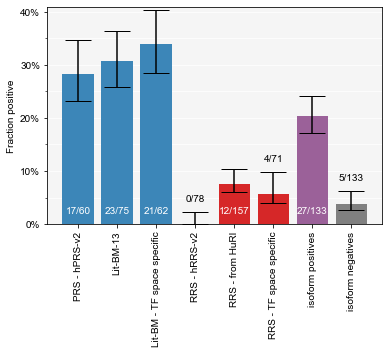

In [11]:
# bar chart
df['result'] = df['NLR'] > df.loc[df['source'] == 'RRS - hRRS-v2', 'NLR'].max()

fig, ax = plt.subplots(1, 1)
validation_plot(data=df,
                selections=[df['source'] == x for x in sources],
                labels=[str(x) for x in sources],
                colors=[colors[x] for x in sources],
                result_column='result',
                errorbar_capsize=0.1,
                y_max=0.41,
                xlabel_rotation=90)
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])
fig.savefig('../figures/TFv02_bar.pdf',
            bbox_inches='tight')

In [12]:
stats.fisher_exact([[27, 133-27], [5, 133-5]])

(6.520754716981132, 4.1504007212818804e-05)

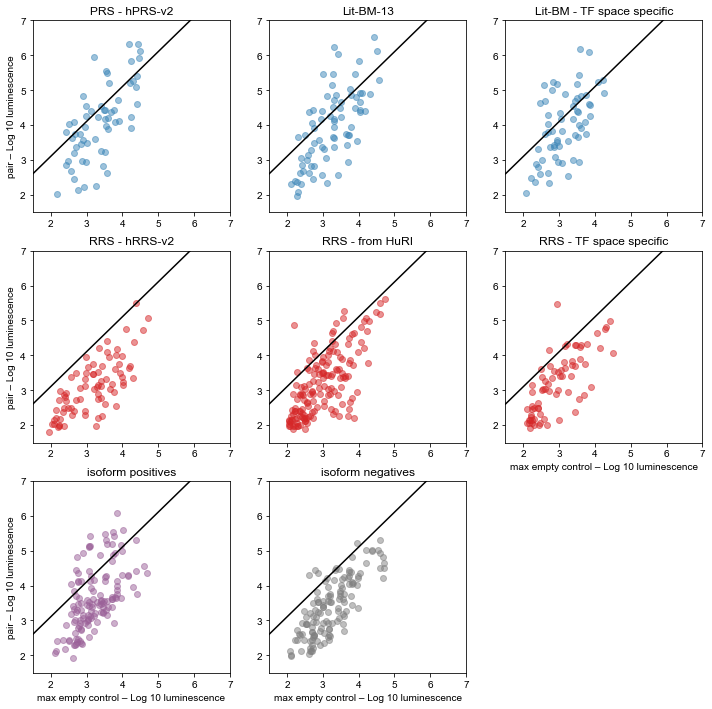

In [13]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(12, 12)
s_min = 1.5
s_max = 7
cutoff = df.loc[df['source'] == 'RRS - hRRS-v2', 'log2 NLR'].max()
for source, ax in zip(sources, axs.flatten()):
    ax.scatter(df.loc[df['source'] == source, ['score_empty-N1_log10', 'score_empty-N2_log10']].max(axis=1).values,
               df.loc[df['source'] == source, 'score_pair_log10'].values,
               color=colors[source],
               alpha=0.5)
    ax.set_title(source)
    ax.set_xlim(s_min, s_max)
    ax.set_ylim(s_min, s_max)
    ax.plot([s_min, s_max],
            [s_min + np.log10(2 ** cutoff), s_max + np.log10(2 ** cutoff)],
             color='black')
for ax in axs[-1, :]:
    ax.set_xlabel('max empty control – Log 10 luminescence')
for ax in axs[:, 0]:
    ax.set_ylabel('pair – Log 10 luminescence')
axs[-1, -1].axis('off')
axs[-2, -1].set_xlabel('max empty control – Log 10 luminescence')
fig.savefig('../figures/TFv02_control-vs-pair_scatter.pdf',
            bbox_inches='tight')

(1.5, 7.0)

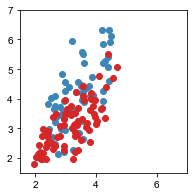

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 3)
for source in ['PRS - hPRS-v2', 'RRS - hRRS-v2']:
    ax.scatter(df.loc[df['source'] == source, ['score_empty-N1_log10', 'score_empty-N2_log10']].max(axis=1).values,
                df.loc[df['source'] == source, 'score_pair_log10'].values,
                color=colors[source])
ax.set_xlim(s_min, s_max)
ax.set_ylim(s_min, s_max)

In [65]:
df.loc[df['log2 NLR'] == df.loc[df['source'] == 'huri_rrs', 'log2 NLR'].max(), :]

,test_orf_ida,test_orf_idb,test_pla,test_pos_pair,score_pair,pair,source,test_pos_empty-N1,score_empty-N1,test_pos_empty-N2,score_empty-N2,NLR,log2 NLR
751,100068172,11034,20,E11,71881,11034_100068172,huri_rrs,F01,158,E12,89,454.943038,8.829542


In [43]:
df.loc[df['log2 NLR'] == df.loc[df['source'] == 'RRS - TF space specific', 'log2 NLR'].max(), :]

,test_orf_ida,test_orf_idb,test_pla,test_pos_pair,score_pair,pair,source,test_pos_empty-N1,score_empty-N1,test_pos_empty-N2,score_empty-N2,NLR,log2 NLR,score_pair_log10,score_empty-N1_log10,score_empty-N2_log10,result
549,3614,100545,13,H05,287134.0,3614_100545,RRS - TF space specific,H07,213.0,H06,872.0,329.28211,8.36318,5.458085,2.32838,2.940516,True


In [45]:
orf_id_to_partner_gene[3614]

'RGS4'

In [ ]:
# don't have this high scoring RRS pair in the VUS data, or either of the two ORFs

In [77]:
df.loc[df['log2 NLR'] == df.loc[df['source'] == 'isoform_matched_negatives', 'log2 NLR'].max(), :]

,test_orf_ida,test_orf_idb,test_pla,test_pos_pair,score_pair,pair,source,test_pos_empty-N1,score_empty-N1,test_pos_empty-N2,score_empty-N2,NLR,log2 NLR
114,10051,100810,3,B12,89998,10051_100810,isoform_matched_negatives,B06,137,B08,103,656.919708,9.359573


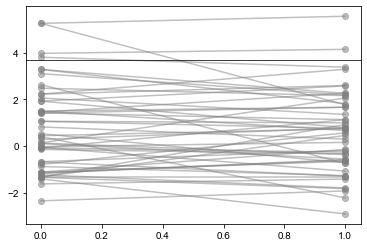

In [15]:
# pair plot
qry = """
select orf_id, symbol, unique_acc
from tf_screen.iso6k_sequences;
"""
iso_orf_id_to_gene = pd.read_sql(qry, paros_connection()).set_index('orf_id')['symbol'].to_dict()
orf_id_to_iso_acc = pd.read_sql(qry, paros_connection()).set_index('orf_id')['clone_acc'].to_dict()
qry = qry = """
select orf_id, entrez_gene_symbol
from hi_ref.master_ref;
"""
orf_id_to_partner_gene = pd.read_sql(qry, paros_connection()).set_index('orf_id')['entrez_gene_symbol'].to_dict()
pairs = []
for _i, row_p in df.loc[df['source'] == 'isoform positives', :].iterrows():
    tf_gene = iso_orf_id_to_gene[row_p['test_orf_idb']]
    for _j, row_n in df.loc[(df['source'] == 'isoform negatives') &
                            (df['test_orf_idb'].map(iso_orf_id_to_gene) == tf_gene) &
                            (df['test_orf_ida'] == row_p['test_orf_ida']), :].iterrows():
        pairs.append((tf_gene, 
                      row_p['test_orf_idb'],
                      row_n['test_orf_idb'],
                      row_n['test_orf_ida'],
                      orf_id_to_iso_acc[row_p['test_orf_idb']],
                       orf_id_to_iso_acc[row_n['test_orf_idb']],
                       orf_id_to_partner_gene[row_n['test_orf_ida']],
                      row_p['log2 NLR'],
                      row_n['log2 NLR']))
pairs = pd.DataFrame(pairs, columns=['TF gene', 
                                     'Y2H_positive_orf_id',
                                     'Y2H_negative_orf_id',
                                     'partner_orf_id',
                                     'Y2H_positive_iso_acc',
                                     'Y2H_negative_iso_acc',
                                     'partner gene',
                                     'log2_NLR_Y2H_positive',
                                     'log2_NLR_Y2H_negative'])
fig, ax = plt.subplots(1, 1)
for _i, pair in pairs.iterrows():
    ax.plot([0, 1], pair[['log2_NLR_Y2H_positive', 'log2_NLR_Y2H_negative']].values, '-o', color='grey', alpha=0.5)
ax.axhline(y=cutoff, color='black', linewidth=0.75)

In [17]:
pairs.sort_values('log2_NLR_Y2H_negative', ascending=False).head()

,TF gene,Y2H_positive_orf_id,Y2H_negative_orf_id,partner_orf_id,Y2H_positive_iso_acc,Y2H_negative_iso_acc,partner gene,log2_NLR_Y2H_positive,log2_NLR_Y2H_negative
19,MEOX1,100645,100810,856,MEOX1|1/3|08C05,MEOX1|2/3|08G04,TCEANC,5.249682,5.554589
4,IKZF2,101070,101390,10016,IKZF2|1/4|02B07,IKZF2|2/4|12C01,IKZF3,3.964003,4.136750
41,MEIS2,100717,101369,8787,MEIS2|1/4|08H09,MEIS2|3/4|11H09,IL16,3.798966,3.370145
28,PATZ1,101008,100444,56482,PATZ1|2/4|02D04,PATZ1|1/4|02C02,IQUB,2.219055,3.284749
27,PATZ1,101008,101054,56482,PATZ1|2/4|02D04,PATZ1|3/4|02A04,IQUB,2.219055,2.589552


In [19]:
# PRS RRS checkerboard
qry = """select plate, well, score
from tf_validation.mn2h_scoring AS b
where standard_batch = 'TFv02'
and plate between 'TFv02N2H_023' and 'TFv02N2H_028';"""
prs = pd.read_sql(qry, paros_connection())
prs = pd.concat([
    (prs.loc[prs['plate'].isin(['TFv02N2H_023', 'TFv02N2H_025', 'TFv02N2H_026']), :]
    .pivot_table(index='well', columns='plate', values='score')
    .reset_index()
    .rename(columns={'TFv02N2H_023': 'test_validation220518', 'TFv02N2H_025': 'empty_F2_control_validation220518', 'TFv02N2H_026': 'empty_F1_control_validation220518'})
    .assign(plate=1)),
    (prs.loc[prs['plate'].isin(['TFv02N2H_024', 'TFv02N2H_027', 'TFv02N2H_028']), :]
    .pivot_table(index='well', columns='plate', values='score')
    .reset_index()
    .rename(columns={'TFv02N2H_024': 'test_validation220518', 'TFv02N2H_027': 'empty_F2_control_validation220518', 'TFv02N2H_028': 'empty_F1_control_validation220518'})
    .assign(plate=2))
])
qry = """select plate, well, orf_ida, symbol_a, orf_idb, symbol_b, category
         from n2h.prsrrs
         where is_v2 = 1;"""
prs = pd.merge(prs,
         pd.read_sql(qry, paros_connection()),
         how='inner',
         on=['plate', 'well'])
qry = """
select plate, well, score
from tf_validation.prs_score
where batch = 'pilot220428';
"""
pilot = pd.read_sql(qry, paros_connection())
pilot = pd.concat([
    (pilot.loc[pilot['plate'].isin(['plate1', 'plate3', 'plate4']), :]
    .pivot_table(index='well', columns='plate', values='score')
    .reset_index()
    .rename(columns={'plate1': 'test_pilot220428', 'plate3': 'empty_F2_control_pilot220428', 'plate4': 'empty_F1_control_pilot220428'})
    .assign(plate=1)),
    (pilot.loc[pilot['plate'].isin(['plate2', 'plate5', 'plate6']), :]
    .pivot_table(index='well', columns='plate', values='score')
    .reset_index()
    .rename(columns={'plate2': 'test_pilot220428', 'plate5': 'empty_F2_control_pilot220428', 'plate6': 'empty_F1_control_pilot220428'})
    .assign(plate=2))
])
prs = pd.merge(prs, pilot, how='inner')

In [20]:
qry = """select a.plate, a.well, 
	   n1n2_r1 as test_Choi_r1, 
		n1f2_r1 as empty_F2_control_Choi_r1,
		f1n2_r1 as empty_F1_control_Choi_r1,
			   n1n2_r2 as test_Choi_r2, 
		n1f2_r2 as empty_F2_control_Choi_r2,
		f1n2_r2 as empty_F1_control_Choi_r2,
			   n1n2_r3 as test_Choi_r3, 
		n1f2_r3 as empty_F2_control_Choi_r3,
		f1n2_r3 as empty_F1_control_Choi_r3,
		 orf_ida, symbol_a, orf_idb, symbol_b, category
from n2h.mn2h_raw as a
left join n2h.mn2h_control_raw as b
on a.plate = b.plate
and a.well = b.well
inner join n2h.prsrrs as c
on a.plate = c.plate
and a.well = c.well
where c.is_v2 = 1;"""
choi = pd.read_sql(qry, paros_connection())
prs = pd.merge(prs, choi, how='inner')

qry = """select distinct ad_orf_id AS orf_ida, db_orf_id AS orf_idb, retest_pla, retest_pos, standard_batch, variant_id, db_source_plate, db_source_well, ad_source_plate, ad_source_well, N2H_raw_r01, N2H_raw_r02 
from vus.retest 
where standard_batch = "mN2Hapwtv2";"""
edge = pd.read_sql(qry, paros_connection())
edge = edge.loc[edge['ad_source_plate'].str.startswith('PRSRRS') | edge['db_source_plate'].str.startswith('PRSRRS'), :]
rows = []
for i in range(0, edge.shape[0], 3):
    rows.append({
    'orf_ida': edge.iloc[i, :]['orf_ida'],
    'orf_idb': edge.iloc[i, :]['orf_idb'],
    'test_edgotyping_r1': edge.iloc[i, :]['N2H_raw_r01'],
    'empty_F2_control_edgotyping_r1': edge.iloc[i+2, :]['N2H_raw_r01'],
    'empty_F1_control_edgotyping_r1': edge.iloc[i+1, :]['N2H_raw_r01'],
    'test_edgotyping_r2': edge.iloc[i, :]['N2H_raw_r02'],
    'empty_F2_control_edgotyping_r2': edge.iloc[i+2, :]['N2H_raw_r02'],
    'empty_F1_control_edgotyping_r2': edge.iloc[i+1, :]['N2H_raw_r02']}
    )
edge = pd.DataFrame(data=rows)
prs = pd.merge(prs, edge, how='inner', on=['orf_ida', 'orf_idb'])

In [22]:
cutoff = {}
for experiment in ['pilot220428', 'validation220518', 'Choi_r1', 'Choi_r2', 'Choi_r3', 'edgotyping_r1', 'edgotyping_r2']:
    prs[f'nlr_{experiment}'] = np.log2(prs[f'test_{experiment}'] / prs[[f'empty_F1_control_{experiment}', f'empty_F2_control_{experiment}']].max(axis=1))
    cutoff[experiment] = prs.loc[prs['category'] == 'RRS', f'nlr_{experiment}'].max()
    prs[f'result_{experiment}'] = prs[f'nlr_{experiment}'] > cutoff[experiment]

In [32]:
prs.head()

,well,test_validation220518,empty_F2_control_validation220518,empty_F1_control_validation220518,plate,orf_ida,symbol_a,orf_idb,symbol_b,category,test_pilot220428,empty_F2_control_pilot220428,empty_F1_control_pilot220428,test_Choi_r1,empty_F2_control_Choi_r1,empty_F1_control_Choi_r1,test_Choi_r2,empty_F2_control_Choi_r2,empty_F1_control_Choi_r2,test_Choi_r3,empty_F2_control_Choi_r3,empty_F1_control_Choi_r3,test_edgotyping_r1,empty_F2_control_edgotyping_r1,empty_F1_control_edgotyping_r1,test_edgotyping_r2,empty_F2_control_edgotyping_r2,empty_F1_control_edgotyping_r2,nlr_pilot220428,result_pilot220428,nlr_validation220518,result_validation220518,nlr_Choi_r1,result_Choi_r1,nlr_Choi_r2,result_Choi_r2,nlr_Choi_r3,result_Choi_r3,nlr_edgotyping_r1,result_edgotyping_r1,nlr_edgotyping_r2,result_edgotyping_r2
0,A01,39940,26232,130,1,1108,LCP2,5001,NCK1,PRS,27970,5453,137,451586,284555,373,599322,758302,427,749721,653100,345,2.289505e+06,72157.333333,133281.333333,3.670188e+06,106002.333333,207970.666667,2.358758,False,0.606507,False,0.666293,False,-0.339441,False,0.199050,False,4.102489,False,4.141402,False
1,A02,5562,8289,117,1,273,FKBP3,5046,NQO2,RRS,3228,3585,144,21407,34787,261,23227,47024,287,39366,19897,278,5.132370e+05,64519.000000,27121.333333,8.464307e+05,77501.666667,58242.000000,-0.151333,False,-0.575594,False,-0.700466,False,-1.017594,False,0.984399,False,2.991829,False,3.449093,False
2,A04,934,728,151,1,2403,ORC2,8578,MCM10,PRS,735,268,130,17071,8553,269,16574,12498,399,22626,13199,390,2.463033e+04,7763.000000,21398.666667,5.929167e+04,16582.666667,22600.000000,1.455511,False,0.359484,False,0.997045,False,0.407225,False,0.777553,False,0.202915,False,1.391507,False
3,A05,165,872,117,1,8536,BDNF,636,NTF4,PRS,185,295,151,1769,12207,213,1882,30012,224,2671,21596,219,5.782000e+03,10059.666667,1635.333333,1.147833e+04,11064.666667,4576.666667,-0.673190,False,-2.401862,False,-2.786703,False,-3.995201,False,-3.015312,False,-0.798942,False,0.052953,False
4,A06,728,240,240,1,2877,RGR,6034,ABCF3,RRS,577,179,130,7225,179,553,7099,185,2225,9447,143,1613,3.864833e+04,1707.000000,16142.666667,6.118700e+04,1127.666667,34426.000000,1.688612,False,1.600904,False,3.707646,False,1.673810,False,2.550110,False,1.259527,False,0.829727,False


In [33]:
pd.set_option('display.max_columns', 100)
prs.sort_values('nlr_edgotyping_r1', ascending=False)

,well,test_validation220518,empty_F2_control_validation220518,empty_F1_control_validation220518,plate,orf_ida,symbol_a,orf_idb,symbol_b,category,test_pilot220428,empty_F2_control_pilot220428,empty_F1_control_pilot220428,test_Choi_r1,empty_F2_control_Choi_r1,empty_F1_control_Choi_r1,test_Choi_r2,empty_F2_control_Choi_r2,empty_F1_control_Choi_r2,test_Choi_r3,empty_F2_control_Choi_r3,empty_F1_control_Choi_r3,test_edgotyping_r1,empty_F2_control_edgotyping_r1,empty_F1_control_edgotyping_r1,test_edgotyping_r2,empty_F2_control_edgotyping_r2,empty_F1_control_edgotyping_r2,nlr_pilot220428,result_pilot220428,nlr_validation220518,result_validation220518,nlr_Choi_r1,result_Choi_r1,nlr_Choi_r2,result_Choi_r2,nlr_Choi_r3,result_Choi_r3,nlr_edgotyping_r1,result_edgotyping_r1,nlr_edgotyping_r2,result_edgotyping_r2
86,B12,117023,50780,103,2,3341,CKB,8297,HBZ,RRS,50862,16840,144,202129,296879,308,240569,716538,708,572397,1014775,477,2.091960e+06,225.333333,1888.000000,1.886292e+06,481.000000,2834.666667,1.594696,False,1.204460,False,-0.554599,False,-1.574592,False,-0.826072,False,10.113781,False,9.378158,False
39,E04,2093079,15295,117,1,3706,BAD,5989,BCL2L1,PRS,1040398,5425,110,5124455,192900,221,7568233,414968,233,12120452,372948,277,4.758852e+07,62325.333333,28572.666667,6.746510e+07,120059.333333,66285.333333,7.583297,True,7.096423,True,4.731474,True,4.188885,True,5.022325,True,9.576579,False,9.134250,False
49,F05,321244,3784,130,1,4265,JUNB,9618,BATF,PRS,137382,1195,158,1660401,82783,227,2169250,111433,203,2395665,79559,227,4.317373e+06,8070.333333,5557.000000,5.372440e+06,8191.333333,9153.333333,6.845039,True,6.407614,True,4.326053,True,4.282948,True,4.912257,True,9.063310,False,9.197064,False
8,A10,35240,948,96,1,6671,SKP1,4656,SKP2,PRS,40215,385,124,1014973,8939,284,826260,32421,478,1195284,26751,430,2.776940e+06,3164.666667,6361.000000,3.168908e+06,6420.666667,9132.666667,6.706731,True,5.216183,True,6.827112,True,4.671595,True,5.481617,True,8.770027,False,8.438734,False
42,E09,163420,4107,96,1,7450,NCBP1,2754,NCBP2,PRS,108047,714,130,1569587,61900,264,1812877,166425,387,3093632,173974,394,3.678516e+06,9128.666667,7796.000000,4.086137e+06,16879.666667,10006.666667,7.241519,True,5.314356,True,4.664302,True,3.445337,True,4.152358,True,8.654504,False,7.919307,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,E01,96,1813,103,2,3425,RXRB,5588,CXCL11,RRS,137,1367,130,904,40325,184,668,73808,123,641,70956,113,1.293333e+03,8575.000000,147.333333,1.764333e+03,14018.000000,206.666667,-3.318765,False,-4.239201,False,-5.479208,False,-6.787785,False,-6.790457,False,-2.729043,False,-2.990085,False
84,B09,151,179,117,2,2826,GPR18,6535,HNRNPLL,RRS,158,151,124,1264,1217,466,1123,1657,1182,1554,1588,971,3.926667e+02,266.333333,2907.500000,8.250000e+02,497.333333,6825.666667,0.065376,False,-0.245411,False,0.054667,False,-0.561216,False,-0.031224,False,-2.888402,False,-3.048504,False
63,H02,165,2026,89,1,7647,PSMD5,1228,SLC22A15,RRS,179,769,117,1382,23227,114,1418,65535,104,1219,65277,123,3.996233e+04,74194.333333,362849.000000,5.636900e+04,171450.666667,602533.666667,-2.103024,False,-3.618096,False,-4.070973,False,-5.530336,False,-5.742805,False,-3.182657,False,-3.418068,False
112,E10,12176,6290,103,2,4687,SMAD4,4735,DCP1A,PRS,4058,2191,103,95220,90388,210,98841,176010,239,160049,173065,227,1.682500e+03,22006.500000,3213.333333,1.662000e+03,40171.333333,6355.333333,0.889179,False,0.952908,False,0.075133,False,-0.832476,False,-0.112800,False,-3.709251,False,-4.595174,False


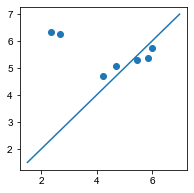

In [42]:
# RRS outlier in VUS experiment
# Did the control fail?
experiments = ['pilot220428', 'validation220518', 'Choi_r1', 'Choi_r2', 'Choi_r3', 'edgotyping_r1', 'edgotyping_r2']
xs = [np.log10(prs.loc[(prs['well'] == 'B12') & (prs['plate'] == 2), 'empty_F2_control_' + e].values[0]) for e in experiments]
ys = [np.log10(prs.loc[(prs['well'] == 'B12') & (prs['plate'] == 2), 'test_' + e].values[0]) for e in experiments]
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 3)
ax.scatter(xs, ys)
ax.plot([s_min, s_max], [s_min, s_max])

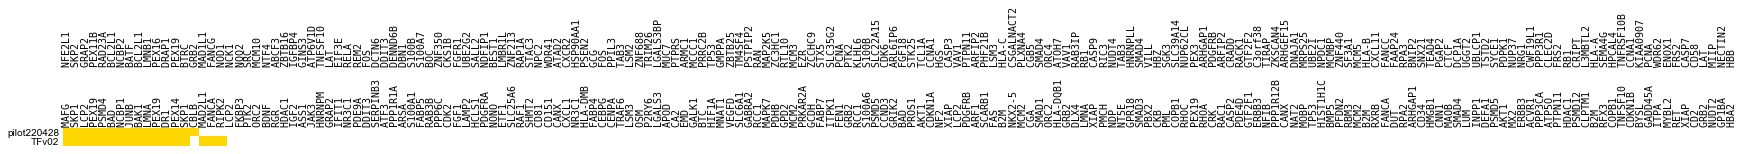

In [156]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(h=4, w=30)
checkerboard(data=prs,
             protein_a_column='symbol_a',
             protein_b_column='symbol_b',
             detection_columns=['result_pilot220428', 'result_validation220518'],
             assay_labels=['pilot220428', 'TFv02'],
             positive_color='gold',
             ax=ax)
fig.savefig('../figures/mN2H-validation-vs-pilot220428_checkerboard.pdf',
            bbox_inches='tight')

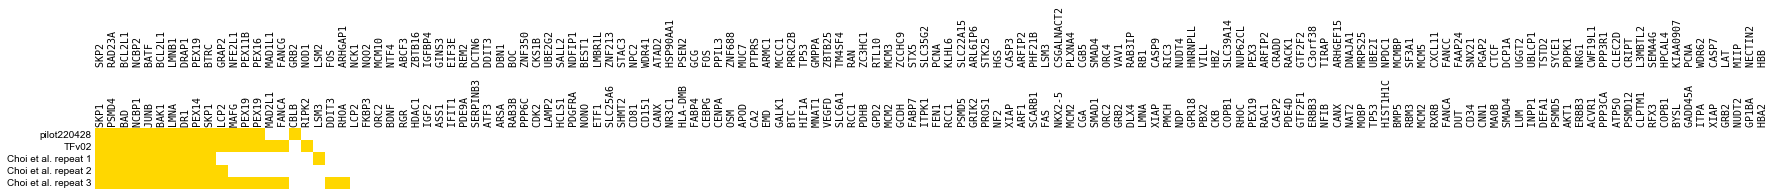

In [34]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(h=4, w=30)
checkerboard(data=prs,
             protein_a_column='symbol_a',
             protein_b_column='symbol_b',
             detection_columns=['result_pilot220428', 
                                'result_validation220518',
                                'result_Choi_r1',
                                'result_Choi_r2',
                                'result_Choi_r3',
                                #'result_edgotyping_r1',
                                #'result_edgotyping_r2'
                                ],
             assay_labels=['pilot220428',
                           'TFv02',
                           'Choi et al. repeat 1',
                           'Choi et al. repeat 2',
                           'Choi et al. repeat 3',
                           #'VUS repeat 1',
                           #'VUS repeat 2'
                           ],
             positive_color='gold',
             ax=ax)
fig.savefig('../figures/TFv02-vs-all_other_mN2H_checkerboard.pdf',
            bbox_inches='tight')

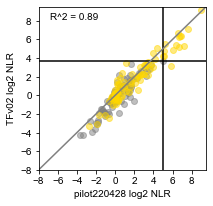

In [155]:
# scatter plots relative to pilot
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(h=3, w=3)
nlr_max = 9.5
nlr_min = -8

ax.axvline(x=cutoff['pilot220428'], color='black')
ax.axhline(y=cutoff['validation220518'], color='black')
ax.scatter(x=prs.loc[prs['category'] == 'RRS', 'nlr_pilot220428'],
            y=prs.loc[prs['category'] == 'RRS', 'nlr_validation220518'],
            color='grey',
            alpha=0.5)
ax.scatter(x=prs.loc[prs['category'] == 'PRS', 'nlr_pilot220428'],
            y=prs.loc[prs['category'] == 'PRS', 'nlr_validation220518'],
            color='gold',
            alpha=0.5)
r2 = stats.pearsonr(prs['nlr_validation220518'].values, prs['nlr_pilot220428'].values)[0] ** 2
ax.text(x=nlr_min*0.85, y=nlr_max*0.85, s=f'R^2 = {r2:.2f}')
ax.plot([nlr_min, nlr_max], [nlr_min, nlr_max], color='grey')
ax.set_xlim(nlr_min, nlr_max)
ax.set_ylim(nlr_min, nlr_max)
ticks = range(nlr_min, int(nlr_max) + 1, 2)
ax.set_yticks(ticks)
ax.set_xticks(ticks)
ax.set_xlabel('pilot220428 log2 NLR')
ax.set_ylabel('TFv02 log2 NLR')
fig.savefig('../figures/pilot220428-vs-validation220518_scatter.pdf',
            bbox_inches='tight')

In [69]:
# vignettes
# group by tf gene
# make checkerboard
vignettes = df.loc[df['source'] == 'vignettes', :].copy()
vignettes['gene_symbol'] = vignettes['test_orf_idb'].map(iso_orf_id_to_gene)
vignettes['clone_acc'] = vignettes['test_orf_idb'].map(orf_id_to_iso_acc)
vignettes['partner'] = vignettes['test_orf_ida'].map(orf_id_to_partner_gene)

In [70]:
vignettes.sort_values(['gene_symbol', 'partner', 'clone_acc'])

,test_orf_ida,test_orf_idb,test_pla,test_pos_pair,score_pair,pair,source,test_pos_empty-N1,score_empty-N1,test_pos_empty-N2,score_empty-N2,NLR,log2 NLR,score_pair_log10,score_empty-N1_log10,score_empty-N2_log10,result,tf_gene,clone_acc,partner
9,54731,101414,1,B06,10583.0,54731_101414,vignettes,B07,117.0,A02,501.0,21.123752,4.400794,4.024609,2.068186,2.699838,True,ATF2,ATF2|1/6|12H04,ATF2
0,54731,101256,1,A01,8351.0,54731_101256,vignettes,A03,137.0,A02,501.0,16.668663,4.059066,3.921738,2.136721,2.699838,True,ATF2,ATF2|2/6|09E05,ATF2
17,54731,101254,1,C07,5686.0,54731_101254,vignettes,C08,124.0,A02,501.0,11.349301,3.504532,3.754807,2.093422,2.699838,False,ATF2,ATF2|3/6|09C05,ATF2
21,54731,100345,1,C11,659.0,54731_100345,vignettes,C12,89.0,A02,501.0,1.315369,0.395468,2.818885,1.949390,2.699838,False,ATF2,ATF2|5/6|09A05,ATF2
25,54731,100448,1,D06,728.0,54731_100448,vignettes,D07,185.0,A02,501.0,1.453094,0.539128,2.862131,2.267172,2.699838,False,ATF2,ATF2|6/6|09H03,ATF2
10,12504,101414,1,B08,3729.0,12504_101414,vignettes,B07,117.0,A05,6709.0,0.555821,-0.847309,3.571592,2.068186,3.826658,False,ATF2,ATF2|1/6|12H04,FOSL2
1,12504,101256,1,A04,6709.0,12504_101256,vignettes,A03,137.0,A05,6709.0,1.000000,0.000000,3.826658,2.136721,3.826658,False,ATF2,ATF2|2/6|09E05,FOSL2
18,12504,101254,1,C09,4876.0,12504_101254,vignettes,C08,124.0,A05,6709.0,0.726785,-0.460400,3.688064,2.093422,3.826658,False,ATF2,ATF2|3/6|09C05,FOSL2
22,12504,100345,1,D01,5995.0,12504_100345,vignettes,C12,89.0,A05,6709.0,0.893576,-0.162338,3.777789,1.949390,3.826658,False,ATF2,ATF2|5/6|09A05,FOSL2
27,12504,100448,1,D08,12321.0,12504_100448,vignettes,D07,185.0,A05,6709.0,1.836488,0.876950,4.090646,2.267172,3.826658,False,ATF2,ATF2|6/6|09H03,FOSL2
